# Importy

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

import eli5

%matplotlib inline

# Wczytywanie danych treningowych z Kaggle

In [2]:
train = pd.read_csv("../train.csv")

# Tworzenie funkcji która transformuje kolumnę datetime

In [3]:
def transform_dates(dataframe):
    dataframe["datetime"] = pd.to_datetime(dataframe["datetime"])
    dataframe["dayofweek"] = dataframe["datetime"].dt.dayofweek      #The day of the week with Monday=0, Sunday=6
    dataframe["year"] = dataframe["datetime"].dt.year
    dataframe["month"] = dataframe["datetime"].dt.month
    dataframe["day"] = dataframe["datetime"].dt.day
    dataframe["hour"] = dataframe["datetime"].dt.hour
    return dataframe

# Używanie funkcji transformującej datetime

In [4]:
train = transform_dates(train)

# Tworzenie X - dataframe ze zmiennymi niezależnymi i y - series ze zmienną zależną

In [5]:
X = train.drop(["count", "casual", "registered", "datetime"], axis = 1)
y = train["count"]

# Chcielibyśmy poznać jakość naszego modelu zanim wyślemy wyniki do Kaggle, w tym celu stworzymy "wewnętrzne" zbiory testowe i treningowe, 33% przeznaczymy na test

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Przygotowujemy parametry dla naszego modelu - RandomForestRegressor

In [7]:
parameters = {'n_estimators': [20], 'max_features': np.arange(0.1, 1.01, 0.1),
              'bootstrap': [True, False]}
forest = RandomForestRegressor()

# Oraz funkcję która będzie go oceniać

In [8]:
def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    return np.sqrt(np.mean((np.log(1+y_pred) - np.log(1+y))**2))

rmsle_score = make_scorer(rmsle, greater_is_better = False)

# Definiujemy naszą funkcję modelującą

In [9]:
regressor = GridSearchCV(estimator = forest, param_grid = parameters, 
                         return_train_score=True, scoring = rmsle_score)

# I ją trenujemy

In [10]:
regressor.fit(X = X_train, y = y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20], 'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

# Sprawdzamy wagi naszych cech po treningu

In [11]:
eli5.explain_weights(regressor.best_estimator_, feature_names=X_train.columns.values)

Weight,Feature
0.5734 ± 0.0544,hour
0.0852 ± 0.0131,year
0.0715 ± 0.0888,atemp
0.0581 ± 0.0391,workingday
0.0437 ± 0.0319,dayofweek
0.0434 ± 0.0536,month
0.0375 ± 0.0539,temp
0.0268 ± 0.0052,humidity
0.0247 ± 0.0401,season
0.0142 ± 0.0044,weather


# Dokonujemy predykcji na wewnętrznym zbiorze testowym

In [12]:
predicted = regressor.predict(X_test)
wyniki = pd.DataFrame(y_test)
wyniki["y_pred"] = predicted
wyniki.rename(columns = {"Klasa":"y_test"}, inplace = True)

# I sprawdzamy wynik

In [13]:
wewnetrzny_test = rmsle(y_pred = wyniki["y_pred"], y = wyniki["count"])
print(wewnetrzny_test)

0.3417627409414503


# Wczytujemy zbiór testowy z kaggle

In [14]:
kaggle = pd.read_csv("../test.csv")
to_submit = kaggle

# Transformujemy daty w taki sam sposób

In [15]:
kaggle = transform_dates(kaggle)
kaggle = kaggle.drop(["datetime"], axis = 1)

# Dokonujemy predykcji

In [16]:
to_submit["count"] = regressor.predict(kaggle)

# I zapisujemy je na dysku w formacie CSV - pierwsze wysłanie wyników

In [17]:
to_submit[["datetime", "count"]].to_csv("../output/{}-results.csv".format(wewnetrzny_test), index = False)

# Wyskalujmy obserwacja od 0 do 1

In [18]:
skaler = MinMaxScaler()
skaler.fit(X_train)

X_train_scaled = skaler.transform(X_train)
X_test_scaled = skaler.transform(X_test)

# Definiujemy domyślne k-średnich

In [19]:
ksrednich = KMeans()

# I je trenujemy

In [20]:
ksrednich.fit(X_train_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

# Zapisujemy je jako nową zmienną w X_train i X_test

In [21]:
X_train["ksrednich"] = ksrednich.predict(X_train_scaled)
X_test["ksrednich"] = ksrednich.predict(X_test_scaled)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# Ponownie trenujemy regressor na rozbudowanych danych

In [22]:
regressor.fit(X = X_train, y = y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [20], 'max_features': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]), 'bootstrap': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(rmsle, greater_is_better=False), verbose=0)

# I sprawdzamy, czy dołożenie nowej cechy coś w ogóle zmieniło

In [23]:
eli5.explain_weights(regressor.best_estimator_, feature_names=X_train.columns.values)

Weight,Feature
0.5806 ± 0.0611,hour
0.0797 ± 0.0297,year
0.0630 ± 0.0716,atemp
0.0465 ± 0.0683,temp
0.0446 ± 0.0333,workingday
0.0408 ± 0.0250,dayofweek
0.0375 ± 0.0372,month
0.0318 ± 0.0151,humidity
0.0202 ± 0.0371,ksrednich
0.0199 ± 0.0428,season


# Sprawdzamy wynik naszego modelu

In [24]:
predicted = regressor.predict(X_test)
wyniki = pd.DataFrame(y_test)
wyniki["y_pred"] = predicted
wyniki.rename(columns = {"Klasa":"y_test"}, inplace = True)

wewnetrzny_test = rmsle(y_pred = wyniki["y_pred"], y = wyniki["count"])
print(wewnetrzny_test)

0.3432247189209896


# Wyskalujmy więc zbiór danych na których mamy dokonać predykcji, dodajmy klasteryzację i dokonajmy predykcji

In [25]:
kaggle_scaled = skaler.transform(kaggle)
kaggle["ksrednich"] = ksrednich.predict(kaggle_scaled)
to_submit["count"] = regressor.predict(kaggle)

# Zapisujemy na dysku - po raz drugi

In [26]:
to_submit[["datetime", "count"]].to_csv("../output/{}-results-kmeans-def.csv".format(wewnetrzny_test), index = False)

# Sprawdźmy jaka liczba k będzie optymalna według silhouette_score

In [27]:
ile_grup = range(2,21)

wyniki = []

for n_grup in ile_grup:    
    ksrednich = KMeans(n_clusters = n_grup, random_state = 42)
    przewidziane = ksrednich.fit_predict(X_train_scaled)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    srednia_sylwetka = silhouette_score(X_train_scaled, przewidziane)
    print("Dla n_grup =", n_grup,
          "średnia sylwetka wynosi:", srednia_sylwetka)
    wyniki.append(srednia_sylwetka)

Dla n_grup = 2 średnia sylwetka wynosi: 0.25248034295122646
Dla n_grup = 3 średnia sylwetka wynosi: 0.23723301578025366
Dla n_grup = 4 średnia sylwetka wynosi: 0.26634534666733484
Dla n_grup = 5 średnia sylwetka wynosi: 0.2374522457629342
Dla n_grup = 6 średnia sylwetka wynosi: 0.2432903553346401
Dla n_grup = 7 średnia sylwetka wynosi: 0.24225291808637864
Dla n_grup = 8 średnia sylwetka wynosi: 0.22472628417519908
Dla n_grup = 9 średnia sylwetka wynosi: 0.22270064162376757
Dla n_grup = 10 średnia sylwetka wynosi: 0.2142226967918112
Dla n_grup = 11 średnia sylwetka wynosi: 0.2093273237192949
Dla n_grup = 12 średnia sylwetka wynosi: 0.2183849838231444
Dla n_grup = 13 średnia sylwetka wynosi: 0.21015373586237976
Dla n_grup = 14 średnia sylwetka wynosi: 0.20156094156321092
Dla n_grup = 15 średnia sylwetka wynosi: 0.20586465853313154
Dla n_grup = 16 średnia sylwetka wynosi: 0.18853376272915426
Dla n_grup = 17 średnia sylwetka wynosi: 0.19269657362418546
Dla n_grup = 18 średnia sylwetka wyno

# I od razu przypiszmy tę liczbę do zmiennej k 

In [28]:
wyniki = pd.Series(wyniki, index=ile_grup)
k = wyniki[wyniki == wyniki.max()].index.item()

# Zobaczmy jescze przy okazji jak wygląda silhouette_score z zależności od k

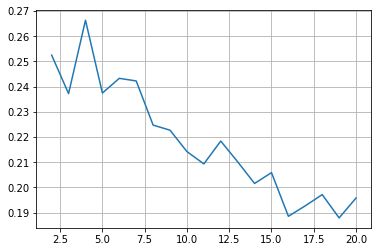

In [29]:
wyniki.plot(grid = True)

# Skoro okazało się, że najlepsze k jest inne niż domyślnie, przeprowadźmy jeszcze raz cały proces

In [30]:
ksrednich = KMeans(n_clusters = k)
ksrednich.fit(X_train_scaled)

X_train["ksrednich"] = ksrednich.predict(X_train_scaled)
X_test["ksrednich"] = ksrednich.predict(X_test_scaled)

regressor.fit(X = X_train, y = y_train)

eli5.explain_weights(regressor.best_estimator_, feature_names=X_train.columns.values)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


Weight,Feature
0.5434 ± 0.0713,hour
0.0984 ± 0.1094,atemp
0.0702 ± 0.0334,year
0.0484 ± 0.0836,temp
0.0430 ± 0.0533,humidity
0.0403 ± 0.0364,month
0.0383 ± 0.0298,ksrednich
0.0355 ± 0.0243,dayofweek
0.0298 ± 0.0338,workingday
0.0147 ± 0.0242,season


# Sprawdzenie jakości modelu

In [31]:
predicted = regressor.predict(X_test)
wyniki = pd.DataFrame(y_test)
wyniki["y_pred"] = predicted
wyniki.rename(columns = {"Klasa":"y_test"}, inplace = True)

wewnetrzny_test = rmsle(y_pred = wyniki["y_pred"], y = wyniki["count"])
print(wewnetrzny_test)

0.3473389095388549


# Dokonajmy finalnej predykcji

In [32]:
kaggle["ksrednich"] = ksrednich.predict(kaggle_scaled)
to_submit["count"] = regressor.predict(kaggle)

# I zapiszmy dane na dysku po raz trzeci

In [33]:
to_submit[["datetime", "count"]].to_csv("../output/{}-results-kmeans-opt.csv".format(wewnetrzny_test), index = False)